In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"

In [2]:


from src.llm.PredictionUtils import init_model_and_tokenizer, llm_gen


model, tokenizer = init_model_and_tokenizer(model_id,
                                            enable_lora=True,
                                            )

INFO 09-20 14:58:31 config.py:904] Defaulting to use mp for distributed inference
INFO 09-20 14:58:31 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-70B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-70B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llam

Loading safetensors checkpoint shards:   0% Completed | 0/30 [00:00<?, ?it/s]


(VllmWorkerProcess pid=754994) INFO 09-20 14:58:51 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-20 14:58:51 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=755000) INFO 09-20 14:58:51 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=754999) INFO 09-20 14:58:52 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=754995) INFO 09-20 14:58:53 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=754997) INFO 09-20 14:58:54 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=754998) INFO 09-20 14:58:54 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=754996) INFO 09-20 14:58:54 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-20 14:59:01 distributed_gpu_executor.py:57] # GPU blocks: 81384, # CPU blocks: 6553
INFO 09-20 14:59:04 model_runner.py:1311] Capturing

In [4]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="Bradley")
ds=ds.shuffle(seed=1)
len(ds)

24889

In [5]:
train_ds = ds.select(range(24000))
test_ds = ds.select(range(24000, 24800))
train_ds[0]



{'CompName': '(2Z)-2-(1,3-Benzodioxol-5-ylmethylene)-6,7-dihydro-5H-[1,3]thiazolo[3,2-a]pyrimidin-3(2H)-one',
 'SMILES': 'O=C1C(SC2=NCCCN12)=Cc4ccc3OCOc3c4',
 'Property': 'Melting temperature',
 'Value': 151.35,
 'unit': '[oC]',
 'Source': 'BradleyMeltingPointDataset'}

In [6]:
import random
prompt_list=[]
problems=[]
n_records=800
target_ds=test_ds
n_records=min(n_records,len(target_ds))
for i in range(n_records):
    record=random.choice(target_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)


In [7]:
import glob
from tqdm import tqdm
from src.prop.utils import parse_Q_R_A_prediction
lora_model_list=glob.glob("output0919_threshold_0.05_lora_kqvo_proj/checkpoint-*")
lora_model_list=glob.glob("output0920_threshold_0.05_lora_kqvo_proj/checkpoint-*")
lora_model_list= sorted(lora_model_list, key=lambda x: int(x.split('-')[-1]))

prediction_dict={}

cnt=0
for lora_model in tqdm(lora_model_list[:]):
    cnt+=1
    predicted_texts=llm_gen(model,prompt_list,
                            enable_lora=True,
                            lora_path=lora_model,
                            lora_id=cnt)
    good_records=parse_Q_R_A_prediction(predicted_texts,problems)
    prediction_dict[lora_model]=good_records

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [19:06<00:00, 286.53s/it]


In [8]:

predicted_texts=llm_gen(model,prompt_list,
                        enable_lora=False,
                        )

Processed prompts: 100%|██████████| 800/800 [01:57<00:00,  6.82it/s, est. speed input: 828.54 toks/s, output: 1879.71 toks/s]


In [9]:

good_records=parse_Q_R_A_prediction(predicted_texts,problems)
prediction_dict["original"]=good_records

could not convert string to float: '105-115'
could not convert string to float: '190-200'
could not convert string to float: '140-160'
could not convert string to float: '120-150'
could not convert string to float: '140-160'
could not convert string to float: '180-200'
could not convert string to float: '180-200'
could not convert string to float: '145-155'
could not convert string to float: '54-60'
could not convert string to float: '145-155'
could not convert string to float: '30-35'
could not convert string to float: '105-115'
could not convert string to float: '55-65'
could not convert string to float: '220-250'
could not convert string to float: '100-140'
could not convert string to float: '202-205'
could not convert string to float: '150-170'
could not convert string to float: '120-140'
could not convert string to float: '120-130'
could not convert string to float: '(5.5'
could not convert string to float: '('
could not convert string to float: '140-150'
could not convert string 

In [10]:
#import json 
#with open("data/predict/0919prediction_dict_kqvo_proj.json","w") as f:
#    json.dump(prediction_dict,f,indent=2)

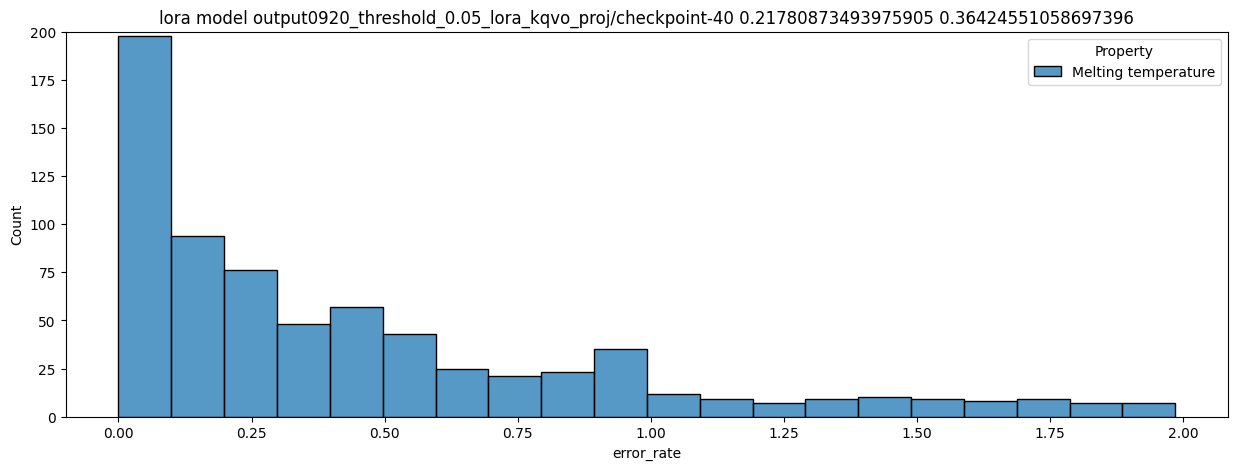

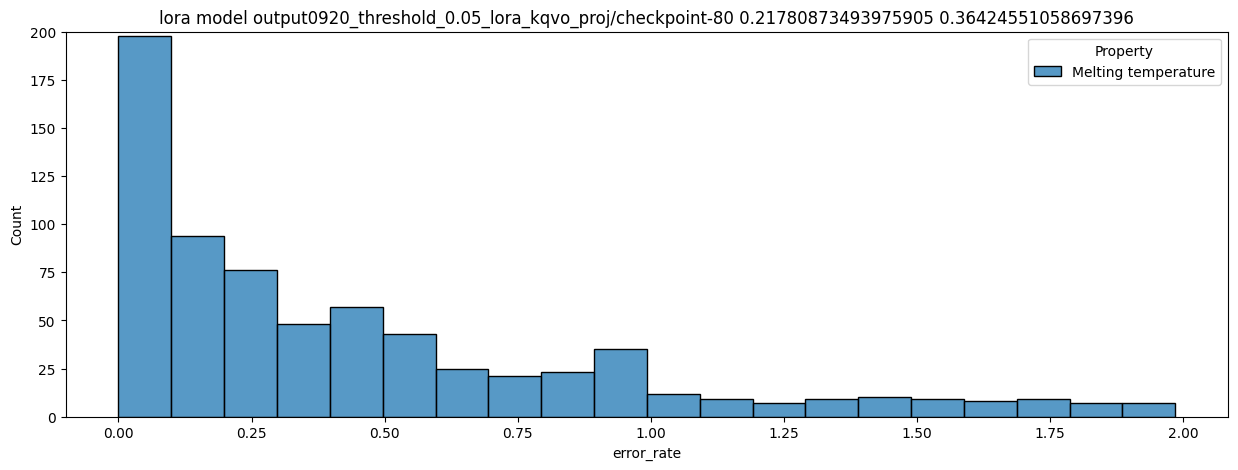

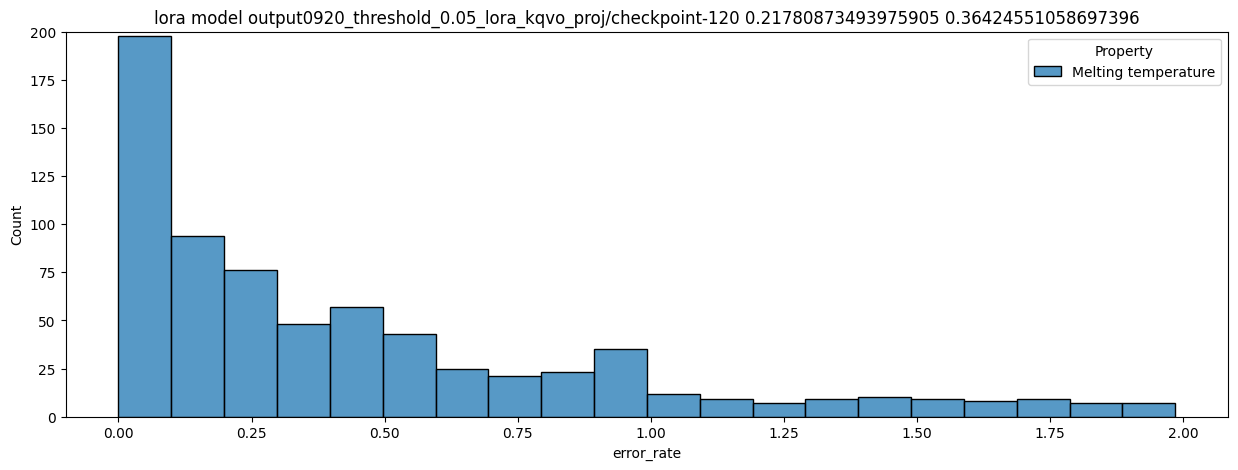

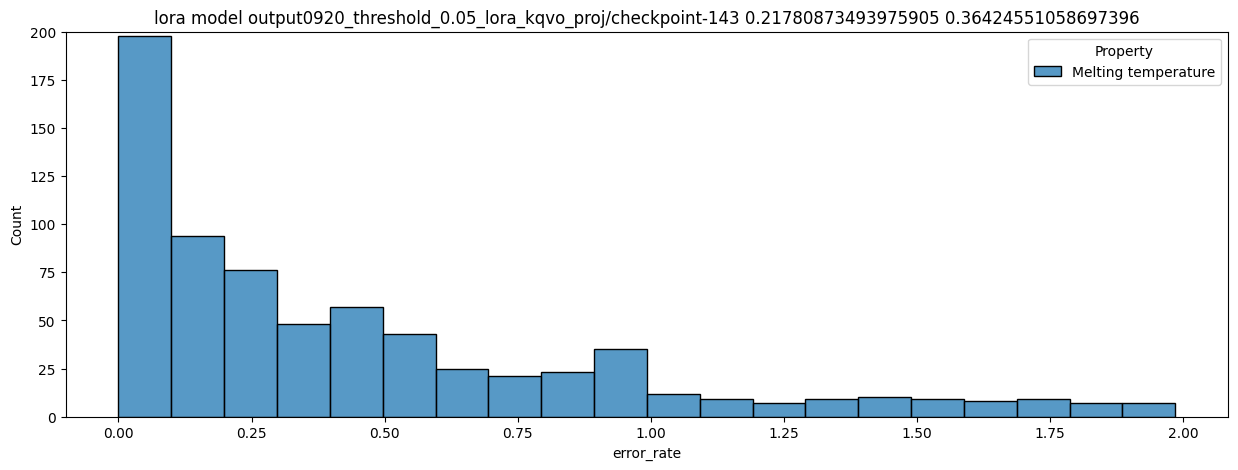

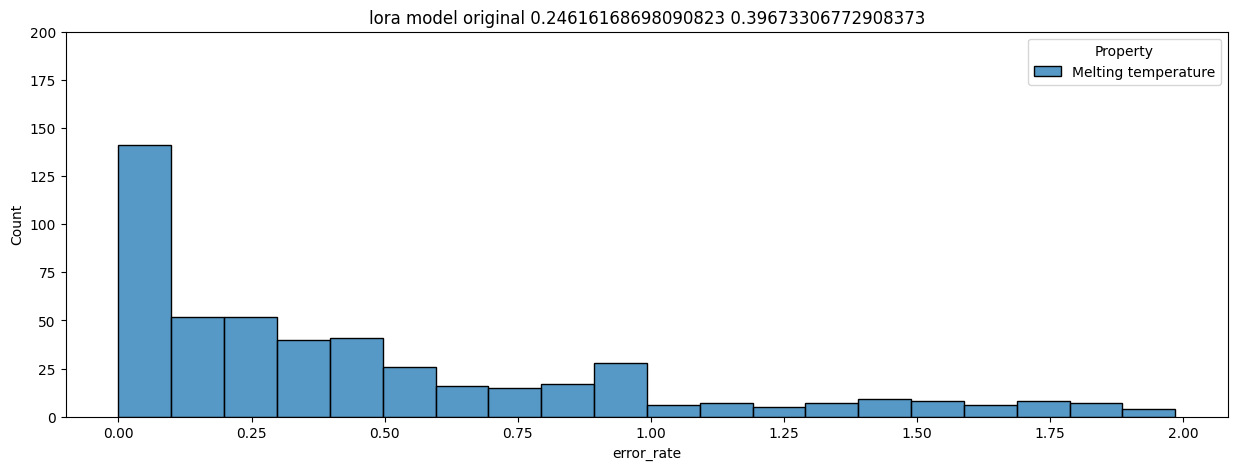

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for lora_name,good_records in prediction_dict.items():

    df=pd.DataFrame(good_records)

    plt.figure(figsize=(15, 5))
    sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
                bins=20)


    s_df=df[df["error_rate"]<1]
    median1=s_df["error_rate"].median()
    median2=df["error_rate"].median()
    plt.title(f"lora model {lora_name} {median1} {median2}")
    plt.ylim(0, 200)